**Laboratorio de métodos cuantitativos aplicados a la Gestión**

---


Clase 8- Modelización de problemas de optimización

Vamos a utilizar lo aprendido en la clase 7 para resolver algunos problemas de optimización. Adicionalmente, vamos a integrar conceptos vistos en las clases 5 y 6 con los de la 7 a modo de consolidación.

In [18]:
!pip install pulp
from pulp import *
import pulp
from scipy.optimize import linprog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Un problema de Riesgo Moral 🙃


El **riesgo moral** ocurre cuando, después de firmar un contrato o establecer una relación (por ejemplo, entre empleador y trabajador, aseguradora y asegurado, banco y prestatario), una de las partes tiene incentivos para cambiar su comportamiento de manera oculta, porque el costo de ese cambio lo soporta en parte la otra parte.


* Hay asimetría de información → una parte no puede observar o verificar completamente las acciones de la otra.

* El agente (quien toma la acción) puede actuar de forma oportunista después de firmado el contrato, eligiendo menos esfuerzo, más riesgo, o desviándose de lo acordado.

* El principal (quien contrata) no puede controlar perfectamente estas acciones, solo observa los resultados.

Una empresa contrata a un trabajador que puede elegir el esfuerzo entre dos niveles:

Esfuerzo alto (H): genera mayores beneficios para la empresa, pero es más costoso para el trabajador.

Esfuerzo bajo (L): genera menores beneficios, pero casi sin costo para el trabajador.

¿Dónde está el riesgo moral acá? El esfuerzo es inobservable para el empleador, lo que hace que pueda estar ofreciendo un salario alto a un trabajador que se esfuerce poco. El empleado tiene incentivos a esforzarse poco (L).

La empresa quiere diseñar un esquema de pagos (según el resultado observado: "éxito" o "fracaso") que:

Minimice el salario esperado a pagar,

Sujeto a:

* El trabajador elige esfuerzo alto (Restricción de compatibilidad de incentivos).

* El trabajador prefiere aceptar el contrato antes que no trabajar (Restricción de participación).

Parámetros:

* Si el trabajador hace esfuerzo alto (H):

 *   Probabilidad de éxito: 0.8
 *   Probabilidad de fracaso: 0.2
 *   Costo de esfuerzo: 2

* Si hace esfuerzo bajo (L):

 * Probabilidad de éxito: 0.5

 * Probabilidad de fracaso: 0.5

 * Costo de esfuerzo: 0

La empresa diseña pagos:
* $w_s$: pago si hay éxito
* $w_f$: pago si hay fracaso


Entonces tenemos que minimizar el salario esperado $0.8w_s + 0.2w_f$, sujeto a:


*   Que el trabajador prefiera el esfuerzo alto: $0.8w_s + 0.2w_f-2\geq0.5w_s + 0.5w_f-0 ⇒ 0.3w_s - 0.3w_f\geq2$

*   Que el trabajador acepte el contrato: $0.8w_s+0.2w_f-2\geq0$
*   No negatividad de salarios: $w_s,w_f \geq0$



In [ ]:
#minimizar salario esperado bajo esfuerzo alto
c = [0.8, 0.2]

#restricciones de desigualdad A_ub x <= b_ub (multiplicamos por -1)
A = [
    [-0.3, 0.3],
    [-0.8, -0.2]
]
b = [-15, -15]

#restricciones de no negatividad
bounds = [(0, None), (0, None)]

#resolvemos
res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method="highs")

print("Resultado óptimo:")
print(f"Pago en éxito (w_s): {res.x[0]:.2f}")
print(f"Pago en fracaso (w_f): {res.x[1]:.2f}")
print(f"Salario esperado mínimo: {res.fun:.2f}")


## Mercado Libre y la distribución de paquetes

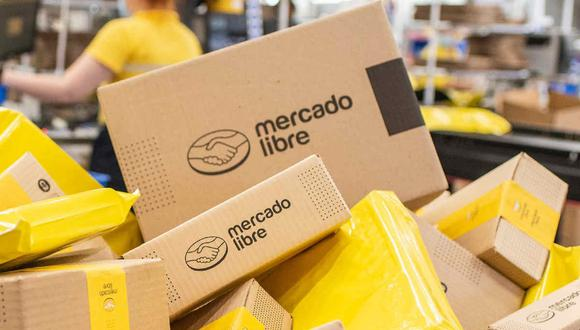

Mercado Libre tiene dos centros de distribución (CDs) y debe enviar paquetes a tres barrios destino.
El objetivo es minimizar el costo de transporte total.

---

La capacidad del CD1 en paquetes es 150, mientras que la del CD2 es 200. El barrio de Almagro demanda 100 paquetes, Balvanera 80 y Recoleta 170. Los costos de envío por paquete en pesos son:


*   CD1: 400 a Almagro, 600 a Balvanera y 800 a Recoleta
*   CD2: 500 a Almagro, 400 a Balvanera y 300 a Recoleta



Formulación del modelo:

minimizar $Z= 400x_{1A} + 600x{1B}+800x_{1R}+500x_{2A}+400x_{2B}+300x_{2R}$

sujeto a:
* La capacidad de cada CD:

  $x_{1A}+x_{1B}+x_{1R} \leq 150\\
  x_{2A}+x_{2B}+x_{2R} \leq 200$
* La demanda de cada barrio:

  $x_{1A}+x_{2A}=100\\
  x_{1B}+x_{2B}=80\\
  x_{1R}+x_{2R}=170$
* No negatividad $x_{ij}\geq 0$

In [ ]:
#creamos el modelo
modelo = pulp.LpProblem("Transporte_MercadoLibre", pulp.LpMinimize)

# Sets
cds = ["CD1", "CD2"]
barrios = ["A", "B", "R"]

#oferta
oferta = {"CD1": 150, "CD2": 200}

#demanda
demanda = {"A": 100, "B": 80, "R": 170}

# Costos
costos = {
    ("CD1", "A"): 400, ("CD1", "B"): 600, ("CD1", "R"): 800,
    ("CD2", "A"): 500, ("CD2", "B"): 400, ("CD2", "R"): 300
}

#variables
x = pulp.LpVariable.dicts("x", (cds, barrios), lowBound=0, cat="Continuous")

#función objetivo
modelo += pulp.lpSum(costos[(i, j)] * x[i][j] for i in cds for j in barrios)

#capacidad de los cd
for i in cds:
    modelo += pulp.lpSum(x[i][j] for j in barrios) <= oferta[i]

#demanda de los barrios
for j in barrios:
    modelo += pulp.lpSum(x[i][j] for i in cds) == demanda[j]

# Resolver
modelo.solve()



In [ ]:
# Resultados
print("Resultado óptimo:")
for i in cds:
    for j in barrios:
        if x[i][j].varValue > 0:
            print(f"Enviar {x[i][j].varValue} paquetes desde {i} a Barrio {j}")

print(f"Costo total mínimo = ${pulp.value(modelo.objective):.2f}")


# Análisis de la base Wage

Suponga que usted es asistente de un especialista en Economía Laboral, quien quiere que analice un conjunto de datos de salarios (Wage.csv).

Calcular:

* El salario promedio, mínimo y máximo.

* La distribución de frecuencias de la variable nivel educativo (si existe una columna de educación).

* La edad promedio y su desviación estándar.

* El salario promedio por grupo etario (ejemplo: menores de 30, entre 30 y 50, mayores de 50).

* El salario promedio por nivel educativo.


In [19]:
wg = pd.read_csv('/content/Wage.csv')
wg

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


In [20]:
print(wg.describe())

#valores faltantes y duplicados
print("\n FALTANTES por columna ")
print(wg.isna().sum())

print("\n FILAS DUPLICADAS ")
print(wg.duplicated().sum())

              year          age      logwage         wage
count  3000.000000  3000.000000  3000.000000  3000.000000
mean   2005.791000    42.414667     4.653905   111.703608
std       2.026167    11.542406     0.351753    41.728595
min    2003.000000    18.000000     3.000000    20.085537
25%    2004.000000    33.750000     4.447158    85.383940
50%    2006.000000    42.000000     4.653213   104.921507
75%    2008.000000    51.000000     4.857332   128.680488
max    2009.000000    80.000000     5.763128   318.342430

 FALTANTES por columna 
year          0
age           0
maritl        0
race          0
education     0
region        0
jobclass      0
health        0
health_ins    0
logwage       0
wage          0
dtype: int64

 FILAS DUPLICADAS 
3


In [21]:
salario_prom = wg["wage"].mean()
salario_min = wg["wage"].min()
salario_max = wg["wage"].max()

print(f"Salario promedio: {salario_prom:.3f}")
print(f"Salario mínimo: {salario_min:.3f}")
print(f"Salario máximo: {salario_max:.3f}")


Salario promedio: 111.704
Salario mínimo: 20.086
Salario máximo: 318.342


In [22]:
dist_educ = wg["education"].value_counts()

print("Distribución de frecuencias de educación:")
print(dist_educ)


Distribución de frecuencias de educación:
education
2. HS Grad            971
4. College Grad       685
3. Some College       650
5. Advanced Degree    426
1. < HS Grad          268
Name: count, dtype: int64


In [23]:
#media y desvío de la edad
edad_prom = wg["age"].mean()
edad_std = wg["age"].std()

print(f"Edad promedio: {edad_prom:.2f}")
print(f"Desviación estándar de la edad: {edad_std:.2f}")


Edad promedio: 42.41
Desviación estándar de la edad: 11.54


In [24]:
#creamos una columna con grupos etarios
wg["grupo_edad"] = pd.cut(wg["age"], bins=[0, 30, 50, 100], labels=["<30", "30-50", ">50"]) #por defecto (0,30]

#salario promedio por grupo etario
salario_por_grupo = wg.groupby("grupo_edad")["wage"].mean()

print("Salario promedio por grupo etario:", salario_por_grupo)

Salario promedio por grupo etario: grupo_edad
<30       89.537073
30-50    116.124255
>50      116.939823
Name: wage, dtype: float64


/tmp/ipython-input-3718810793.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  salario_por_grupo = wg.groupby("grupo_edad")["wage"].mean()


In [25]:
#salario promedio por nivel educativo
salario_por_educ = wg.groupby("education")["wage"].mean()

print("Salario promedio por nivel educativo:", salario_por_educ)

Salario promedio por nivel educativo: education
1. < HS Grad           84.104415
2. HS Grad             95.783351
3. Some College       107.755566
4. College Grad       124.427908
5. Advanced Degree    150.917776
Name: wage, dtype: float64


Crear:

* Un histograma de salarios.

* Un nuevo DataFrame que contenga únicamente los individuos con salario mayor al promedio.

* Un DataFrame resumen con las siguientes métricas:
   * Salario promedio general
   * Salario promedio por nivel educativo.




  

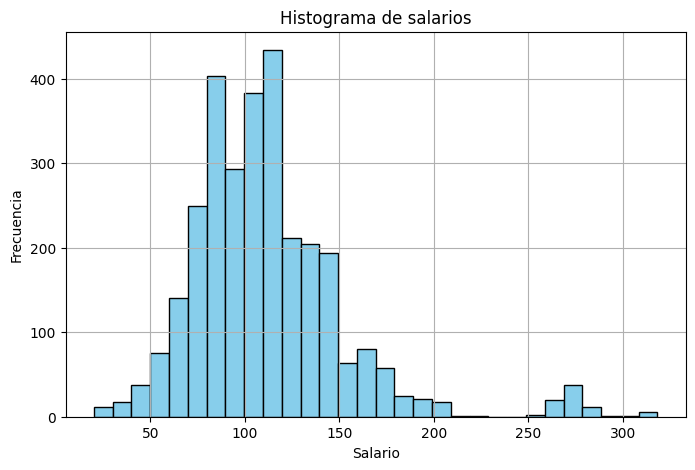

In [26]:
plt.figure(figsize=(8,5))
plt.hist(wg["wage"], bins=30, color="skyblue", edgecolor="black")
plt.title("Histograma de salarios")
plt.xlabel("Salario")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

In [28]:
salario_promedio = wg["wage"].mean()

#filtramos individuos con salario mayor al promedio
wg_mayores = wg[wg["wage"] > salario_promedio]

wg_mayores.head()


,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage,grupo_edad
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177,30-50
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293,30-50
5,2008,54,2. Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,4.845098,127.115744,>50
6,2009,44,2. Married,4. Other,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.133021,169.528538,30-50
7,2008,30,1. Never Married,3. Asian,3. Some College,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.716003,111.720849,<30


In [29]:
#salario promedio por nivel educativo
salario_educ = wg.groupby("education")["wage"].mean()

#DataFrame resumen
resumen = pd.DataFrame({
    "Salario promedio general": [salario_promedio],
}).T  # lo ponemos como fila

#unimos con el promedio por educación
resumen_educ = salario_educ.to_frame(name="Salario promedio por educación")

print("Resumen general:")
print(resumen)
print('Resumen por nivel educativo:')
print(resumen_educ)

Resumen general:
                                   0
Salario promedio general  111.703608
Resumen por nivel educativo:
                    Salario promedio por educación
education                                         
1. < HS Grad                             84.104415
2. HS Grad                               95.783351
3. Some College                         107.755566
4. College Grad                         124.427908
5. Advanced Degree                      150.917776


## Asignación Óptima de Personal con la base Wage

Imaginen que son parte del recruiting de una empresa. Necesitan decidir cuántos empleados asignar a dos clases de trabajo diferentes (`Industrial` e `Information`) para minimizar la nómina total de salarios, pero tienen restricciones basadas en su presupuesto y las políticas de la empresa **derivadas del conjunto de datos.**

Usaremos el dataset `Wage.csv` para calcular **parámetros realistas** para nuestro modelo.
Variables de Decisión:

Sea $x_1$ el número de empleados contratados en el sector
`Industrial`.

Sea $x_2$ el número de empleados contratados en el sector `Information`.

**Función Objetivo**:

Queremos minimizar el costo total de salarios para la empresa.

salario_promedio_industrial = Salario promedio en el sector `Industrial` (del dataset)

salario_promedio_informacion = Salario promedio en el sector `Information` (del dataset)

Minimizar:

$Z=$ `salario_promedio_industrial` $x_1 +$ `salario_promedio_informacion` $x_2$


**Restricciones**:

* Requerimiento Mínimo de Personal: Para cumplir con las órdenes de trabajo, necesitan al menos un total de 100 empleados. $→x_1+x_2 \geq100$
* Restricción de Habilidades (Política): El departamento de `Information` es crucial para la empresa, por lo que debe constituir al menos el 40% de la fuerza laboral total. $→x_2\geq 0.4(x_1+x_2)$
* Restricción de Presupuesto Máximo: La gerencia ha establecido un tope máximo para la nómina. Vamos a usar el percentil 75 (Q3) del salario del dataset multiplicado por 120 (un poco más que el mínimo de 100 empleados) para establecer un límite máximo realista pero ajustado:
  * ` tope_presupuesto`= salario en el percentil 75 * 120

   (`salario_promedio_industrial` $× x_1$) + (`salario_promedio-informacion` $×x_2$) $\leq$ ` tope_presupuesto`

* Restricciones de no negatividad $→x_1,x_2\geq0$



In [30]:
#calculamos los parámetros clave del dataset
salario_promedio_industrial = wg[wg['jobclass'] == '1. Industrial']['wage'].mean()
salario_promedio_informacion = wg[wg['jobclass'] == '2. Information']['wage'].mean()
salario_q3 = wg['wage'].quantile(0.75)

personal_minimo_total = 100
tope_presupuesto = salario_q3 * 120 #presupuesto máximo para ~120 empleados

print("Parámetros Calculados desde el Dataset:")
print(f"Salario Promedio (Industrial): ${salario_promedio_industrial:.2f}")
print(f"Salario Promedio (Information): ${salario_promedio_informacion:.2f}")
print(f"Salario en el Percentil 75 (Q3): ${salario_q3:.2f}")
print(f"Personal Mínimo Requerido: {personal_minimo_total} empleados")
print(f"Tope Máximo de Presupuesto: ${tope_presupuesto:.2f}")



Parámetros Calculados desde el Dataset:
Salario Promedio (Industrial): $103.32
Salario Promedio (Information): $120.59
Salario en el Percentil 75 (Q3): $128.68
Personal Mínimo Requerido: 100 empleados
Tope Máximo de Presupuesto: $15441.66


In [31]:
modelo = pulp.LpProblem("Minimizacion_Costos_Laborales", pulp.LpMinimize)

x1 = pulp.LpVariable('Num_Trabajadores_Industriales', lowBound=0, cat='Integer')
x2 = pulp.LpVariable('Num_Trabajadores_Informacion', lowBound=0, cat='Integer')

#función Objetivo: MINIMIZAR el costo total
modelo += (salario_promedio_industrial * x1) + (salario_promedio_informacion * x2), "Costo_Total_Salarios"

#restricciones
modelo += x1 + x2 >= personal_minimo_total, "Requerimiento_Minimo_de_Personal"
modelo += -0.4 * x1 + 0.6 * x2 >= 0, "Politica_Minima_de_Informacion"
modelo += (salario_promedio_industrial * x1) + (salario_promedio_informacion * x2) <= tope_presupuesto, "Tope_Maximo_de_Presupuesto"

modelo.solve()
estado = pulp.LpStatus[modelo.status]

print(f"Estado de la Solución: {estado}\n")

if estado == 'Optimal':
    print("SOLUCIÓN ÓPTIMA ENCONTRADA")
    print(f"Para minimizar los costos de nómina necesitando al menos {personal_minimo_total} empleados:")
    print(f"Contrate {int(x1.varValue)} trabajadores industriales.")
    print(f"Contrate {int(x2.varValue)} trabajadores de información.")
    print(f"-Total de empleados: {int(x1.varValue + x2.varValue)}")
    print(f"-Los trabajadores de información son el {(x2.varValue / (x1.varValue + x2.varValue)) * 100:.1f}% del total.")
    print(f"\nCosto total de nómina semanal: ${pulp.value(modelo.objective):.2f}")
    print(f"(Este costo está por debajo del tope de ${tope_presupuesto:.2f})")
else:
    print("No se encontró una solución óptima. Es posible que las restricciones sean demasiado estrictas.")


Estado de la Solución: Optimal

SOLUCIÓN ÓPTIMA ENCONTRADA
Para minimizar los costos de nómina necesitando al menos 100 empleados:
Contrate 60 trabajadores industriales.
Contrate 40 trabajadores de información.
-Total de empleados: 100
-Los trabajadores de información son el 40.0% del total.

Costo total de nómina semanal: $11022.98
(Este costo está por debajo del tope de $15441.66)


# 🥇 ⚡ 🤓 Hagamos un mini-solver

In [17]:
print("⭐ Bienvenido al mini-solver de Programación Lineal ⭐\n")

#tipo de problema
tipo = input("¿Desea maximizar o minimizar la función objetivo? (max/min): ").strip().lower()

#cantidad de variables y restricciones
n_vars = int(input("Ingrese la cantidad de variables de decisión: "))
n_rest = int(input("Ingrese la cantidad de restricciones: "))

#coeficientes de la función objetivo
print("\nFunción objetivo: Z = c1*x1 + c2*x2 + ... + cn*xn")
c = []
for i in range(n_vars):
    coef = float(input(f"Ingrese el coeficiente c{i+1}: "))
    c.append(coef)

#ajuste según el tipo de problema
if tipo == "max":
    c = [-ci for ci in c]  #porque linprog solo minimiza!!!

c = np.array(c)

#restricciones
A = []
b = []
print("\nRestricciones (del tipo <=):")
for j in range(n_rest):
    fila = []
    for i in range(n_vars):
        aij = float(input(f"Coeficiente de x{i+1} en restricción {j+1}: "))
        fila.append(aij)
    rhs = float(input(f"Término independiente (lado derecho) de restricción {j+1}: "))
    A.append(fila)
    b.append(rhs)

A = np.array(A)
b = np.array(b)

#resolver
res = linprog(c, A_ub=A, b_ub=b, bounds=[(0, None)]*n_vars, method="highs")

#resultados
if res.success:
    print("\n✅ Resultado óptimo encontrado:")
    for i, val in enumerate(res.x):
        print(f"x{i+1} = {val:.2f}")
    if tipo == "max":
        print(f"Valor óptimo Z = {-res.fun:.2f}")
    else:
        print(f"Valor óptimo Z = {res.fun:.2f}")
else:
    print("\n⚠️ No se encontró una solución factible.")


⭐ Bienvenido al mini-solver de Programación Lineal ⭐



KeyboardInterrupt: Interrupted by user

Actividad propuesta:

Una empresa necesita contratar empleados en dos áreas: Backend y Data. La empresa tiene que decidir cuántos empleados contratar en cada área para:

Minimizar la nómina total (suma de salarios promedio por cantidad contratada).

Cumplir con:

* Al menos 10 empleados en total.

* Al menos 3 de Backend y 3 de Data.

* La suma de scores (score promedio × cantidad contratada) debe ser al menos 600.

Para esto, cuenta con un dataset del desempeño de sus empleados en dichas áreas (disponible en el campus). Formular y resolver el problema de programación lineal con PuLP haciendo uso del dataset disponible.


Fuentes:

Notas de álgebra teórico-prácticas: cátedra de Álgebra / Alicia Delia Fraquelli;Andrea Leonor Gache. - 1a ed. - Ciudad Autónoma de Buenos Aires: Universidad de Buenos Aires. Facultad de Ciencias Económicas, 2019.

Hilpisch, Y. (2018). Python for Finance: Mastering Data-Driven Finance (2nd ed.). O’Reilly Media.

James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor, J. (2023). An Introduction to Statistical Learning: with Applications in Python. Springer.